TODO

1. Conferir perguntas Decision Stump
2. Adicionar Pesos dos pontos

In [184]:
import os, time, math, random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.max_rows = 10

In [187]:
data2 = pd.read_csv('data/tic-tac-toe.data', header=None)
data2

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


In [190]:
# Armazenar o label correto dos numeros
data = data2.rename(columns = {9:'label'})
data['label'] = data['label'].replace({'positive': 1, 'negative': -1})

y = data.label
X = data.drop("label", axis=1)

# Separar 20% para teste
# train = data.sample(frac = 0.8)
# test = data.drop(train.index)

# X = train
# y = test

# y_train = train.label
# y_test  = test.label

# # Retirar a primeira coluna referente aos labels
# X_train = train.drop("label", axis=1)
# X_test  = test.drop("label", axis=1)

In [181]:
def k_fold(dataset, folds=5):
    indexes_split = []
    indexes = list(dataset.index)
    fold_size = int(dataset.shape[0] / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(indexes))
            fold.append(indexes.pop(index))
            indexes_split.append(fold)
    return indexes_split

In [118]:
class DecisionStump:
    def __init__(self):
        # Possiveis categorias que o dado vai ter para poder realizar as perguntas (Tem x na posição 0?)
        # No caso do tick-tack-toe vai ser x, o e b
        self.unique_categories = []
        # Dimensionalidade do dado, para saber quantas possíveis posições pode ter
        self.data_dimension = 0
        
        self.model = {
            'question_column' : None,
            'question_cat'    : None,
            'value'           : None,
            'train_weighted_error' : None,
            'train_accuracy'       : None
        }
        
    def fit(self, X, y, weights):
        """Seleciona o modelo com base em X, y e os pesos de cada entrada"""
        
        # Guarda todos os valores possiveis para todas as colunas e a dimensao dos dados
        # No caso do Tick-Tack-Toe, sera x,o,b para todas
        for column in X:
            self.unique_categories.append(X[column].unique())
        self.data_dimension = len(list(X))
        
        best_model_error = 1
        for i in range(0, self.data_dimension):
            for cat in self.unique_categories[0]:
                for value in (-1, 1):
                    error = self._compute_training_error(X, y, i, cat, value, weights=weights)
                    if (error[0] < best_model_error):
                        best_model_error  = error[0]
                        self.model['question_column'] = i
                        self.model['question_cat']    = cat
                        self.model['value']           = value
                        self.model['train_weighted_error'] = error[0]
                        self.model['train_acccuracy']      = error[1]
        return self
    
    def predict(self, X):
        """Prevê os valores das entradas em X"""
        if (self.model['question_column'] == None):
            print('Model was not fitted')
            return
        
        predictions = []
        for row in X:
            if( row[self.model['question_column']] == self.model['question_cat'] ):
                predictions.append(self.model['value'])
            else:
                predictions.append(-self.model['value'])
        return predictions
    
    def _compute_training_error(self, X, y, question_column, question_cat, value, weights=None):
        nb_samples  = X.count()[0]
        right_count = 0
        error = 0
        for i, row in X.iterrows():
            if( (row[question_column] == question_cat and y[i] == value) or 
                  (row[question_column] != question_cat and y[i] != value) ):
                right_count += 1
            else:
                error += weights[i]
        
        accuracy = right_count / float(nb_samples)
        # Error is weighted error
        return (error, accuracy)
    
    def get_empirical_weighted_error(self):
        return self.model['train_weighted_error']
    
    def get_empirical_accuracy(self):
        return self.model['train_acccuracy']
    
# dt = DecisionStump()
# weights = pd.Series(index=y_train.index.copy())
# weights[:] = 1.0 / y_train.shape[0]
# dt.fit(X_train, y_train, weights = weights)

# predictions = dt.predict(X_test.values)
# right_count = 0
# for i, row in enumerate(predictions):
#     if (predictions[i] == y_test.values[i]):
#         right_count += 1
# print('Accuracy on test: {}'.format(right_count / float(len(y_test.values))) )

Accuracy on test: 0.6927083333333334


In [119]:
# print(dt.get_empirical_weighted_error())
# print(dt.get_empirical_accuracy())


0.29895561357702466
0.7010443864229765


In [146]:
class AdaBoost:
    def __init__(self, nb_estimators = 30):
        self.nb_estimators = nb_estimators
        self.models  = []
        self.weights = []
        self.alphas  = []
        
        self.models_error_rate = []
        
    def fit(self, X, y):
        
        # Calculate initial weights
        weights = pd.Series(index=y.index.copy())
        weights[:] = 1.0 / y.shape[0]
        self.weights.append( weights )
        
        for i in range(0, self.nb_estimators):
            # Calculate new models
            dt = DecisionStump()
            dt.fit(X, y, self.weights[i])
            self.models.append(dt)
            self.models_error_rate.append(1.0-dt.get_empirical_accuracy())
            
            # Calculate new alpha
            error = dt.get_empirical_weighted_error()
            alpha = 0.5 * math.log( (1 - error) / error )
            self.alphas.append(alpha)
            
            # Calculate new weights
            new_weights = pd.Series(index=y.index.copy())
            right_count = 0
            for index, _ in new_weights.iteritems():
                prediction = dt.predict(np.array([ X.loc[index].values ]))[0]
                true_y     = y[index]
                new_weights[index] = self.weights[i][index] * math.exp( -alpha * prediction * true_y )
                    
            new_weights = new_weights.apply(lambda x: float(x) / new_weights.sum())
            self.weights.append( new_weights )
        
        return self
    
    def _sign(self, value):
        if (value >= 0):
            return 1
        return -1
    
    def predict(self, X):
        """Prevê os valores das entradas em X"""
        if ( len(self.models) == 0 ):
            print('Model was not fitted')
            return
        
        predictions = []
        for row in X:
            sum_predictions = np.sum([ dt.predict([row])[0] * self.alphas[i] for i,dt in enumerate(self.models)])
            predictions.append( self._sign(sum_predictions))
        return predictions
    
    def compute_ensemble_error_rate(self, X, y):
        if ( len(self.models) == 0 ):
            print('Model was not fitted')
            return
        
        ensemble_error_rate = []
        for j in range(1, len(self.models)+1):
            right_count = 0
            for z, row in enumerate(X):
                sum_predictions = np.sum(
                    [ dt.predict([row])[0] * self.alphas[i] for i,dt in enumerate(self.models[0:j])])
                if (self._sign(sum_predictions) == y[z]):
                    right_count += 1
            accuracy = right_count / float(y.shape[0])
            ensemble_error_rate.append( 1-accuracy )
                
        return ensemble_error_rate

# for estimators in range(2, 8):
#     start = time.time()
#     adb = AdaBoost(nb_estimators=estimators)
#     adb.fit(X_train, y_train)
#     end = time.time()
#     predictions = adb.predict(X_test.values)
#     right_count = 0
#     for i, row in enumerate(predictions):
#         if (predictions[i] == y_test.values[i]):
#             right_count += 1
    
#     accuracy = right_count / float(len(y_test.values))
#     xs.append(estimators)
#     ys.append(accuracy)
    
#     print('Fitting took {} seconds'.format(end-start))
#     print('Accuracy on test with {} estimators: {}'.format(estimators, accuracy))

In [198]:
indexes = k_fold(X, folds=5)
print(len(indexes))
#for i, test_indexes in enumerate(indexes):
#    print(i)
# adb = AdaBoost(nb_estimators=50)
# start = time.time()
# adb.fit(X_train, y_train)
# end   = time.time()
# print('Fitting took {} seconds'.format(end-start))
# ensemble_err_train = adb.compute_ensemble_error_rate(X_train.values, y_train.values)
# enemble_err_test  = adb.compute_ensemble_error_rate(X_test.values, y_test.values)
# model_err_train    = adb.models_error_rate

955


In [166]:
def plot_loss_curve(xs, ensemble_training_error, ensemble_test_error, model_err_train):
    fig = plt.figure(figsize=(9, 9), dpi= 80)
    plt.style.use('ggplot')
    plt.title('Loss Curve')
    plt.ylabel('Error Rate')
    plt.xlabel('Number of Weak Learners')
    plt.plot(xs, ensemble_training_error, 'bo-', label="Ensemble Training Error")
    plt.plot(xs, ensemble_test_error, 'ro-', label="Ensemble Test Error")
    plt.plot(xs, model_err_train, 'mo-', label="Weak Model Training Error")
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/data/alexandremaros/git/adaboost/venv-ada/lib/python3.4/site-packages/matplotlib/pyplot.py'>

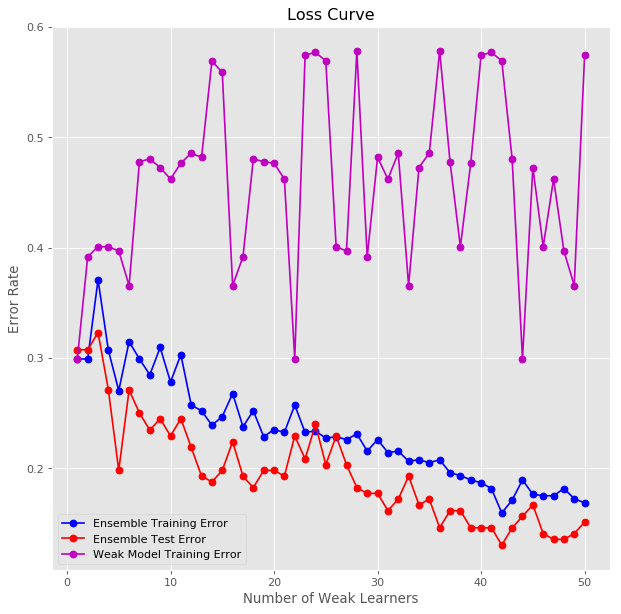

In [167]:
plot_loss_curve([x for x in range(1,51)], ensemble_err_train, enemble_err_test, model_err_train )